In [4]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import gc
from importlib import reload

In [5]:
import data
import analysis
import ratios_fit
import jackknife as jk

# Load Data

In [7]:
# Since measurements can take up a lot of memory, deleting old data before loading more can prevent a crash
try:
    del measurements
    gc.collect()
except:
    pass

# Parameters
Nt = 1000
dt = 0.1

alpha = 1.0
beta = 9.0
barrier_strength = 100.0
FV_offset = 0.3
TV_offset = 0.0
eps = 1e-10

t_full1 = 5
t_full2 = 6

M = "1.0"
L = "0.0"
P = "1.0"
t_FV = "*"

version = "10-2"
date = "*" #datetime.datetime.now().date()

cutoff = 10000
block_size = 2000

measurements = data.Data(cutoff, block_size)

fileid = f"{1}x{Nt}_alpha_{alpha}_beta_{beta}_dt_{dt}_FVoff_{FV_offset}_TVoff_{TV_offset}_bar_{barrier_strength}_M_{M}_L_{L}_P_{P}_eps_{eps}_tfull1_{t_full1}_tfull2_{t_full2}_*_tFV_{t_FV}_*_{date}_{version}"
print(fileid)
measurements.load(f"../../../data/measurements_{fileid}.bin")
#measurements.load(f"output_data/measurements_{fileid}.bin")

1x1000_alpha_1.0_beta_9.0_dt_0.1_FVoff_0.3_TVoff_0.0_bar_100.0_M_1.0_L_0.0_P_1.0_eps_1e-10_tfull1_5_tfull2_6_*_tFV_*_*_*_10-2
Loading ../../../data/measurements_1x1000_alpha_1.0_beta_9.0_dt_0.1_FVoff_0.3_TVoff_0.0_bar_100.0_M_1.0_L_0.0_P_1.0_eps_1e-10_tfull1_5_tfull2_6_proj2_True_ins_True_tTV_50_tFV_939_tFVout_444_tFVmid_51_2025-02-06_10-2.bin ...
Loading ../../../data/measurements_1x1000_alpha_1.0_beta_9.0_dt_0.1_FVoff_0.3_TVoff_0.0_bar_100.0_M_1.0_L_0.0_P_1.0_eps_1e-10_tfull1_5_tfull2_6_proj2_True_ins_True_tTV_10_tFV_979_tFVout_464_tFVmid_51_2025-02-06_10-2.bin ...
Loading ../../../data/measurements_1x1000_alpha_1.0_beta_9.0_dt_0.1_FVoff_0.3_TVoff_0.0_bar_100.0_M_1.0_L_0.0_P_1.0_eps_1e-10_tfull1_5_tfull2_6_proj2_True_ins_True_tTV_20_tFV_969_tFVout_459_tFVmid_51_2025-02-06_10-2.bin ...
Loading ../../../data/measurements_1x1000_alpha_1.0_beta_9.0_dt_0.1_FVoff_0.3_TVoff_0.0_bar_100.0_M_1.0_L_0.0_P_1.0_eps_1e-10_tfull1_5_tfull2_6_proj2_True_ins_True_tTV_60_tFV_929_tFVout_439_tFVmid_51_20

Check to make sure that the data look reasonable

In [8]:
reload(analysis)
an = analysis.Analysis(measurements)

an.check_data()

(980.0, 999.0)

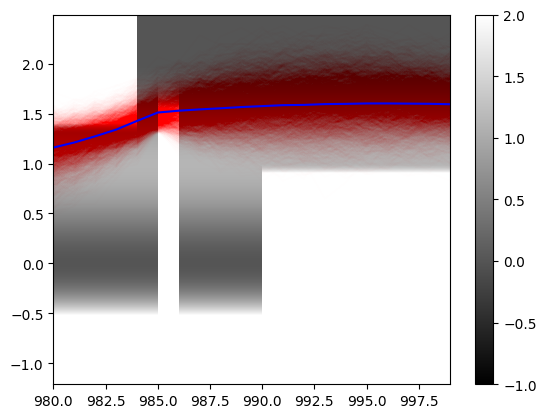

In [9]:
fig, ax = plt.subplots()

params = {"Nt": Nt, "alpha": alpha, "beta": beta, "dt": dt, "bar": barrier_strength, "M": 1.0, "L": 0.0, "tfull1": 5, "tTV": 10}
an.plot_potential(params, xmin=-1, xmax=2.5, fig=fig, ax=ax, cmap="grey")
an.plot_paths(params, sampling_freq = 10, cutoff=measurements.cutoff, ax=ax, alpha=0.002, color="red")
an.plot_mean_path(params, ax=ax)
ax.set_xlim([980, 999])

# Analysis

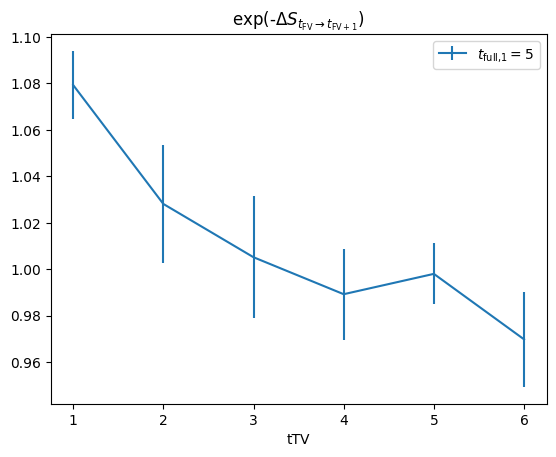

In [11]:
reload(analysis)
an = analysis.Analysis(measurements)
#measurements.block_size = 200

params_tFV = {"Nt": Nt, "alpha": alpha, "beta": beta, "dt": dt, "bar": barrier_strength, "M": 1.0, "L": 0.0, "P": 1.0, "tfull1": t_full1, "tfull2": t_full2, "proj2": True, "ins": True}

t_TVs1, ratios1, dS_errs1 = an.plot_exp_Ebar_blocks("tTV", params=params_tFV, get_x=lambda sf: int(measurements.params[sf]["tTV"])*dt, filter_x=lambda t: t>6.6, label="$t_\\text{full,1}=$"+str(t_full1))

plt.legend()

In [ ]:
an.plot_expS_vs_P()
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

In [41]:
params = {"Nt": Nt, "alpha": alpha, "beta": beta, "dt": dt, "M": 1.0, "L": 0.0, "P": 0.0, "bar": barrier_strength, "tfull1": t_full1, "tfull2": t_full2, "tTV": 10, "proj2": True, "ins": False}

#Ms = [0.0, 0.001, 0.004, 0.008, 0.02, 0.03, 0.04, 0.08, 0.2, 0.5, 0.8, 1.0]
#Ls = [0.0, 0.001, 0.004, 0.008, 0.02, 0.03, 0.04, 0.08, 0.2, 0.5, 0.8, 1.0]
Ms = [0.0, 0.001, 0.004, 0.008, 0.02, 0.03, 0.04, 0.08, 0.2, 0.5, 0.8, 1.0]
Ls = [0.0, 0.001, 0.004, 0.008, 0.02, 0.04, 0.08, 0.2, 0.5, 0.8, 1.0]
Ps = [0.0, 0.01, 0.02, 0.04, 0.08, 0.5, 0.8, 1.0]

measurements.cutoff = 10000

measurements.block_size = 2000

#R_blocks = an.get_R_blocks(Ms, Ls, params1)
P_blocks = an.get_P_blocks(Ps, params)
ddR_over_R_blocks = jk.super_jackknife_combine_blocks(P_blocks, lambda x: an.calc_P_ratio(x))
#ddR_blocks = np.divide(an.get_ddR_blocks(Ms, Ls, Ps, params1), dt**2)
#ddR_blocks = an.get_ddR_div_R_blocks(an.data.get_indices(params1)[0])
#print(f"R: {jk.get_errors_from_blocks(np.mean(R_blocks), R_blocks)}")
print(f"ddR: {jk.get_errors_from_blocks(np.mean(ddR_over_R_blocks), ddR_over_R_blocks)}")

ddR: [np.float64(0.05257161021677405), np.float64(0.004308597250088971)]


In [34]:
params1 = {"Nt": Nt, "alpha": alpha, "beta": beta, "dt": dt, "bar": barrier_strength, "tfull": t_full1, "tTV": 50}

Ms = [0.0, 0.001, 0.004, 0.008, 0.02, 0.03, 0.04, 0.08, 0.2, 0.5, 0.8, 1.0]
Ls = [0.0, 0.001, 0.004, 0.008, 0.02, 0.03, 0.04, 0.08, 0.2, 0.5, 0.8, 1.0]

measurements.block_size = 2000

gamma_mean1, gamma_blocks1 = an.calc_gamma_blocks(Ms, Ls, 0.3, 1.1, params1)
print(f"gamma 1: {jk.get_errors_from_blocks(gamma_mean1, gamma_blocks1)}")

NameError: name 't_full1' is not defined

In [8]:
params2 = {"Nt": Nt, "alpha": alpha, "beta": beta, "dt": dt, "bar": barrier_strength, "tfull": t_full2, "tTV": 50}
gamma_mean2, gamma_blocks2 = an.calc_gamma_blocks(Ms, Ls, 0.3, 1.1, params2)
print(f"gamma 2: {jk.get_errors_from_blocks(gamma_mean2, gamma_blocks2)}")

Based on mean, ratios fit is: 0.0320301380259386
Correction factor estimated: 0.0320301380259386
R ratio estimated: 4.108445437397901e-05
gamma 2: [np.float64(0.00020651216173183702), np.float64(1.5647837099315915e-05)]


In [9]:
gamma_sub_mean = an.calc_gamma_sub(gamma_mean1,t_full1,gamma_mean2,t_full2)
gamma_sub_blocks = an.calc_gamma_sub_blocks(gamma_blocks1, t_full1, gamma_blocks2, t_full2)
print(f"gamma subtracted: {jk.get_errors_from_blocks(np.mean(gamma_sub_blocks), gamma_sub_blocks)}")
print(f"gamma subtracted without bias correction: {gamma_sub_mean}")

gamma subtracted: [np.float64(0.0004066226901440335), np.float64(7.911934705695094e-05)]
gamma subtracted without bias correction: 0.0004066199683450917


In [27]:
gamma_der_mean, gamma_der_blocks = an.calc_gamma_blocks(Ms, Ls, 0.3, 1.1, params1, der=True)
print(f"gamma der: {jk.get_errors_from_blocks(gamma_der_mean, gamma_der_blocks)}")

Based on mean, ratios fit is: 0.11384806036047697
Correction factor estimated: 0.11384806036047697
R ratio estimated: -5.121822393597479e-05
gamma der: [np.float64(-0.0036625458197395862), np.float64(0.0005357756369700459)]


In [34]:
reload(analysis)
an = analysis.Analysis(measurements)

In [36]:
an.calc_gamma_div(gamma_mean1, gamma_der_mean*0.02, t_full1, 0.02)

np.float64(2.2436573037439512e-08)

## Contribution to Total Error from Each ML-Ratio Ensemble

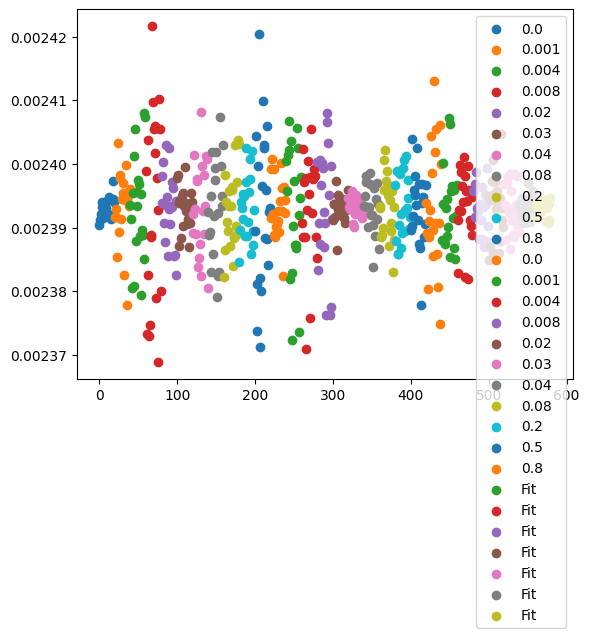

In [10]:
n_blocks_per_ensemble = int((50000 - measurements.cutoff) / measurements.block_size)
labels = Ms[:-1] + Ls[:-1] + ["Fit"]*100
for i in range(int(len(gamma_blocks1)/n_blocks_per_ensemble)):
    plt.scatter(np.array(range(n_blocks_per_ensemble)) + i*n_blocks_per_ensemble, gamma_blocks1[i*n_blocks_per_ensemble:(i+1)*n_blocks_per_ensemble], label = f"{labels[i]}")
plt.legend()

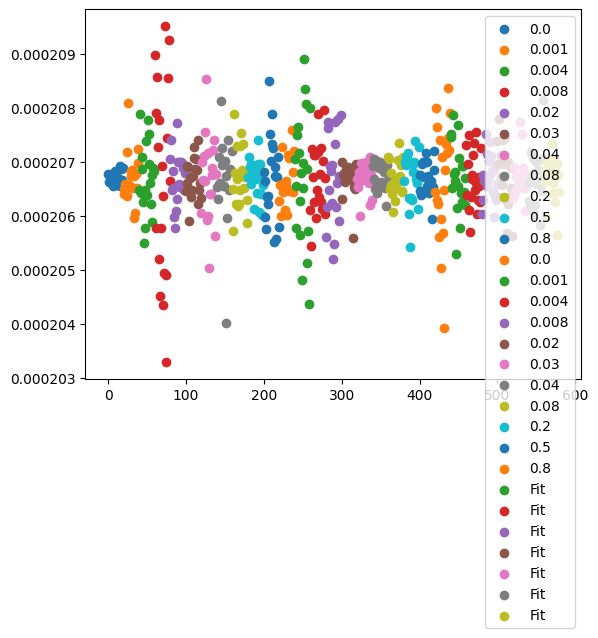

In [11]:
n_blocks_per_ensemble = int((50000 - measurements.cutoff) / measurements.block_size)
labels = Ms[:-1] + Ls[:-1] + ["Fit"]*100
for i in range(int(len(gamma_blocks2)/n_blocks_per_ensemble)):
    plt.scatter(np.array(range(n_blocks_per_ensemble)) + i*n_blocks_per_ensemble, gamma_blocks2[i*n_blocks_per_ensemble:(i+1)*n_blocks_per_ensemble], label = f"{labels[i]}")
plt.legend()

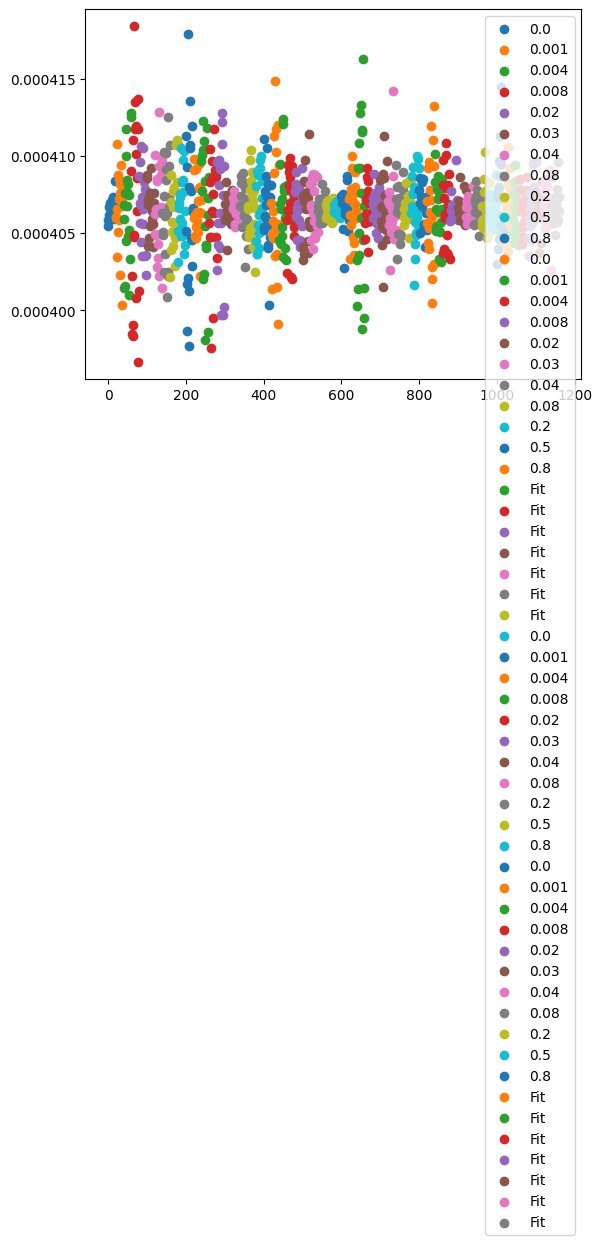

In [13]:
n_blocks_per_ensemble = int((50000 - measurements.cutoff) / measurements.block_size)
n_ensembles = int(len(gamma_sub_blocks)/n_blocks_per_ensemble)
n_fit_ensembles = int(n_ensembles/2) - len(Ms) + 1 - len(Ls) + 1

labels = Ms[:-1] + Ls[:-1] + ["Fit"]*n_fit_ensembles + Ms[:-1] + Ls[:-1] + ["Fit"]*n_fit_ensembles
for i in range(n_ensembles):
    plt.scatter(np.array(range(n_blocks_per_ensemble)) + i*n_blocks_per_ensemble, gamma_sub_blocks[i*n_blocks_per_ensemble:(i+1)*n_blocks_per_ensemble], label = f"{labels[i]}")
plt.legend()